## Check simulations of BDs

In [9]:
import sys
sys.path.append("../python/")
sys.path.append("../python/cluster")

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import bokeh.palettes
import imp
from matplotlib.offsetbox import AnchoredText
import mock_generation
imp.reload(mock_generation)
from mock_generation import mock_population
from astropy.constants import R_jup, M_jup, M_sun, L_sun
from scipy.interpolate import interp1d, interp2d
from utils import temperature, heat, temperature_withDM

from matplotlib import rc
rc('font', family='times new roman', size=22.)

### Empirical space densities at the Solar neighbourhood

Data below is taken from Table 15 of [Kirkpatrick + '20](https://arxiv.org/abs/2011.11616)

In [3]:
# temperature [K]
bin_edges = [300, 450, 600, 750, 900, 1050, 1200, 1350, 1500, 1650, 1800, 1950, 2100, 2250] 
# space density [x 1e-3 pc-3]
rho       = [2.84, 4.24, 2.80, 1.99, 1.72, 1.11, 1.95, 0.94, 0.81, 0.78, 0.50, 0.72, 0.31] 
error_rho = [np.nan, 0.70, 0.37, 0.32, 0.30, 0.25, 0.30, 0.22, 0.20, 0.20, 0.17, 0.18, np.nan]

bins = np.zeros(len(rho))

for i in range(len(rho)):
    bins[i] = 0.5*(bin_edges[i] + bin_edges[i+1])

#TODO - need to plot arrows for lower limits

Text(0.5, 0, '$T_{\\rm eff}$ [K]')

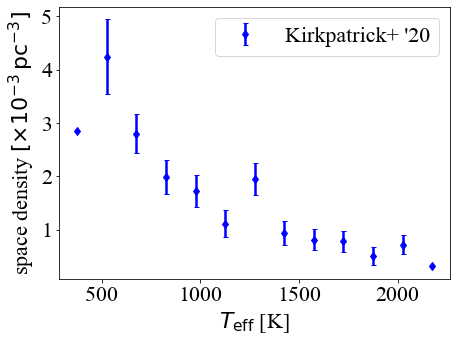

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.errorbar(bins, rho, error_rho, fmt="d", elinewidth=2.5, capsize=2.5, label="Kirkpatrick+ '20", color="blue")

ax.legend()
ax.set_ylabel(r"space density $\rm [\times 10^{-3}\,pc^{-3}]$")
ax.set_xlabel(r"$T_{\rm eff}$ [K]")

### Spatial distribution

In [57]:
def f_bulge(r, phi, theta, R0=8.178, x0=0.899, y0=0.386, z0=0.250, alpha=0.415):
    """
    Stanek + '97: E2 bulge
    (all spatial coordiantes are given in kpc)
    """
    x0 = x0*R0/8. # rescale to adopted R0 value
    y0 = y0*R0/8. 
    # return
    return np.exp(-np.sqrt(np.sin(theta)**2*((np.cos(phi+alpha)/x0)**2 + (np.sin(phi+alpha)/y0)**2) + 
                           (np.cos(theta)/z0)**2)*r)

def f_disc(r, theta, R0=8.178, Rd=2.15, zh=0.40):
    """
    Bovy and Rix disc
    (all spatial coordiantes are given in kpc)
    """
    Rd = Rd*R0/8. # rescale to adopted R0 value
    # return
    return np.exp(-r*np.sin(theta)/Rd)*np.exp(-r*np.cos(theta)/zh)


def prob_dens(r, phi, theta, R0=8.178):
    _f = f_bulge(r, phi, theta, R0)
    # return
    return np.heaviside(1.-r, 1.)*_f + np.heaviside(r-1., 0.)*f_disc(r, theta, R0)

In [62]:
def spatial_sampling(nBDs, phi=0., theta=np.pi/2., R0=8.178):
    
    ymin = 0.1; ymax = R0
    umin = np.min([prob_dens(ymin, phi, theta), prob_dens(1., phi, theta), prob_dens(R0, phi, theta)])
    umax = np.max([prob_dens(ymin, phi, theta), prob_dens(1., phi, theta), prob_dens(R0, phi, theta)])
    
    i = 0
    r = np.ones(nBDs)*100
    while i<nBDs:
        yi = np.random.uniform(ymin, ymax)
        ui = np.random.uniform(umin, umax)
        if ui < prob_dens(yi, phi, theta, R0):
            r[i] = yi
            i+=1
        else:
            continue
    # return 
    return r

In [69]:
r = spatial_sampling(10000)

In [75]:
from scipy.integrate import quad

A = quad(prob_dens, 0.1, 8.178, args=(0., np.pi/2., ))

print(A)

(1.7806335394673694, 8.830473299665356e-09)


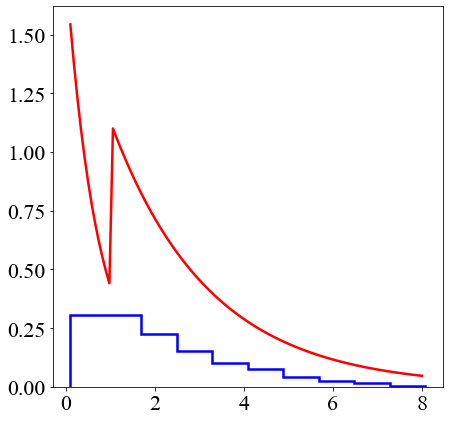

In [82]:
# TODO : NEED TO CHECK RESULTS

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

radius = np.linspace(0.1, 8., 100)

ax.plot(radius, prob_dens(radius, 0., np.pi/2.)*A[0], color="red", lw=2.5)

_, _, _ = ax.hist(r, histtype="step", linewidth=2.5, color="blue", density=True)

### Adding uncertainty on mass of BDs

In [24]:
nBDs         = 100
rel_unc_Tobs = 0.05
rel_mass     = 0.05
f_true       = 1.
gamma_true   = 1.
rs_true      = 20.

r_obs, Tobs, rel_unc_Tobs, Teff, mass, mass_obs, log_ages = mock_population(nBDs, rel_unc_Tobs, rel_mass, f_true, 
                                                                            gamma_true, rs_true=rs_true)

In [25]:
np.mean(np.abs(mass_obs-mass)/mass)

<Quantity 0.04965806>